In [1]:
# Load packages

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import cmasher as cmr
import random
from unyt import Msun, yr, Mpc, angstrom
import seaborn as sns
import pandas as pd
import os
from matplotlib.gridspec import GridSpec

from synthesizer.grid import Grid
from synthesizer.load_data.load_scsam import load_SCSAM
from synthesizer.emission_models import (
    BlackHoleEmissionModel,
    GalaxyEmissionModel,
    StellarEmissionModel,
    AttenuatedEmission,
    TotalEmission
)
from synthesizer.particle.galaxy import Galaxy as ParticleGalaxy
from synthesizer.particle.stars import Stars as ParticleStars
from synthesizer.particle import BlackHoles, Gas
from synthesizer.emission_models.attenuation import ParametricLi08

plt.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 14})

In [12]:
sam_dir = '/mnt/ceph/users/lperez/AGNmodelingSCSAM/sam_newAGNcode_allzs_Sophie/h5files'
sv = "0_0_0"

with h5py.File(f'{sam_dir}/volume.hdf5', 'r') as file:

    # Load properties
    stellar_mass = file[f'{sv}/Galprop/GalpropMstar'][:] * 1e9 # Msolar
    metal_mass = file[f'{sv}/Galprop/GalpropZcold'][:] * 1e9 # Msolar Zsolar
    disk_radius = file[f'{sv}/Galprop/GalpropRdisk'][:] # kpc
    halo_radius = file[f'{sv}/Galprop/GalpropRhalo'][:] # Mpc
    redshift = file[f'{sv}/Galprop/GalpropRedshift'][:] 
    gas_mass = file[f'{sv}/Galprop/GalpropMcold'][:] * 1e9 # Msolar

# Filter for a given redshift range 
redshift_mask = (redshift >= 0) & (redshift < 0.1)
stellar_mass = stellar_mass[redshift_mask]
metal_mass = metal_mass[redshift_mask]
disk_radius = disk_radius[redshift_mask]
halo_radius = halo_radius[redshift_mask]
gas_mass = gas_mass[redshift_mask]
redshift = redshift[redshift_mask]
print(len(disk_radius))

Z_gas = metal_mass / gas_mass # Zsolar
halo_disk_ratio = halo_radius * 1e3 / disk_radius
gas_radius = disk_radius * 1.68 * 2 # kpc

print(min(gas_mass), max(gas_mass))

# Filter using Z_gas etc
met_mask = (Z_gas < 2) & (halo_disk_ratio < 1e3) & (gas_mass > 0) & np.isfinite(Z_gas)
stellar_mass_filtered = stellar_mass[met_mask]
metal_mass_filtered = metal_mass[met_mask]
disk_radius_filtered = disk_radius[met_mask]
gas_mass_filtered = gas_mass[met_mask]
redshift_filtered = redshift[met_mask]
gas_radius_filtered = gas_radius[met_mask]

print(len(redshift_filtered))

print(100 - 100 * len(redshift_filtered) / len(redshift) )

149033
0.0 8.88981e+10
140170
5.947005025732551


/tmp/ipykernel_1784321/1969120816.py:24: RuntimeWarning: divide by zero encountered in divide
  Z_gas = metal_mass / gas_mass # Zsolar
/tmp/ipykernel_1784321/1969120816.py:24: RuntimeWarning: invalid value encountered in divide
  Z_gas = metal_mass / gas_mass # Zsolar


In [13]:
# Compute A_v values
indices = np.arange(len(disk_radius))
cosine_incs = np.random.uniform(0.2, 0.98, len(disk_radius))
cosine_incs_filtered = np.random.uniform(0.2, 0.98, len(disk_radius_filtered))
cosine_incs = 1
k_v = 3.4822e4  # cm^2/g

#Av_values = 4.4e-3 * (1 / cosine_incs) * k_v * (metal_mass / 1e10) * (disk_radius ** -2)
log_Av_values = np.log(4.4e-3) - np.log(cosine_incs) + np.log(k_v) + np.log(metal_mass / 1e10) - 2*np.log(gas_radius)
Av_values = np.exp(log_Av_values)

print(max(Av_values))

log_Av_filtered = np.log(4.4e-3) - np.log(cosine_incs) + np.log(k_v) + np.log(metal_mass_filtered / 1e10) - 2*np.log(gas_radius_filtered)
Av_filtered = np.exp(log_Av_filtered)
print(max(Av_filtered))

#Av_values = 4.4e-3 * (1 / cosine_incs) * k_v * Z_gas * (gas_mass / 1e10) * (disk_radius ** -2)
#print(max(Av_values))

# Filter values with Av > 100
mask = Av_values > 100

# Combine into a DataFrame
df = pd.DataFrame({
    'redshift': redshift[mask],
    'stellar_mass_Msun': stellar_mass[mask],
    'gas_mass_Msun': gas_mass[mask],
    'metal_mass_Msun': metal_mass[mask],
    'disk_radius_kpc': disk_radius[mask],
    'Z_gas_Zsolar': Z_gas[mask],
    'Av_mag': Av_values[mask]
})

# Save to CSV
output_path = f'/mnt/home/snewman/ceph/large_Av_z0-0.1.csv'
df.to_csv(output_path, index=False)

print(f"Saved {len(df)} entries to {output_path}")

# Filter values with Av < 1
mask = Av_values < 1

# Combine into a DataFrame
df = pd.DataFrame({
    'redshift': redshift[mask],
    'stellar_mass_Msun': stellar_mass[mask],
    'gas_mass_Msun': gas_mass[mask],
    'metal_mass_Msun': metal_mass[mask],
    'disk_radius_kpc': disk_radius[mask],
    'Z_gas_Zsolar': Z_gas[mask],
    'Av_mag': Av_values[mask]
})

# Save to CSV
output_path = f'/mnt/home/snewman/ceph/small_Av_z0-0.1.csv'
df.to_csv(output_path, index=False)

print(f"Saved {len(df)} entries to {output_path}")

# Filter values with Av < 1
mask = Av_values < 0.5

# Combine into a DataFrame
df = pd.DataFrame({
    'redshift': redshift[mask],
    'stellar_mass_Msun': stellar_mass[mask],
    'gas_mass_Msun': gas_mass[mask],
    'metal_mass_Msun': metal_mass[mask],
    'disk_radius_kpc': disk_radius[mask],
    'Z_gas_Zsolar': Z_gas[mask],
    'Av_mag': Av_values[mask]
})

# Save to CSV
output_path = f'/mnt/home/snewman/ceph/Av_0.5_z0-0.1.csv'
df.to_csv(output_path, index=False)

print(f"Saved {len(df)} entries to {output_path}")

/tmp/ipykernel_1784321/2462762259.py:9: RuntimeWarning: divide by zero encountered in log
  log_Av_values = np.log(4.4e-3) - np.log(cosine_incs) + np.log(k_v) + np.log(metal_mass / 1e10) - 2*np.log(gas_radius)
/tmp/ipykernel_1784321/2462762259.py:14: RuntimeWarning: divide by zero encountered in log
  log_Av_filtered = np.log(4.4e-3) - np.log(cosine_incs) + np.log(k_v) + np.log(metal_mass_filtered / 1e10) - 2*np.log(gas_radius_filtered)


6575.5219090788205
93.69277461825824
Saved 103 entries to /mnt/home/snewman/ceph/large_Av_z0-0.1.csv
Saved 141456 entries to /mnt/home/snewman/ceph/small_Av_z0-0.1.csv
Saved 135259 entries to /mnt/home/snewman/ceph/Av_0.5_z0-0.1.csv


In [6]:
df = pd.read_csv('/mnt/home/snewman/ceph/large_Av_z0-0.1.csv')

# Derive main controlling term
df["term"] = df["Z_gas_Zsolar"] * (df["gas_mass_Msun"] / 1e10) * (df["disk_radius_kpc"] ** -2)

# Check correlation
print(df[["term", "Av_mag", "disk_radius_kpc", "Z_gas_Zsolar", "gas_mass_Msun"]].corr())

# Look at top offenders
print('Largest Av values:')
print(df.nlargest(5, "Av_mag")[["disk_radius_kpc", "Z_gas_Zsolar", "gas_mass_Msun", "metal_mass_Msun", "Av_mag"]])

# Look at Av of around 100
df = pd.read_csv('/mnt/home/snewman/ceph/small_Av_z0-0.1.csv')
print('Av of around 100:')
print(df.nlargest(5, "Av_mag")[["disk_radius_kpc", "Z_gas_Zsolar", "gas_mass_Msun", "metal_mass_Msun", "Av_mag"]])

# Look at Av of around 0.5
df = pd.read_csv('/mnt/home/snewman/ceph/Av_0.5_z0-0.1.csv')
print('Smallest Av values:')
print(df.nlargest(5, "Av_mag")[["disk_radius_kpc", "Z_gas_Zsolar", "gas_mass_Msun", "metal_mass_Msun", "Av_mag"]])

                     term    Av_mag  disk_radius_kpc  Z_gas_Zsolar  \
term             1.000000  1.000000        -0.131362      0.060330   
Av_mag           1.000000  1.000000        -0.131362      0.060330   
disk_radius_kpc -0.131362 -0.131362         1.000000      0.561976   
Z_gas_Zsolar     0.060330  0.060330         0.561976      1.000000   
gas_mass_Msun    0.357470  0.357470         0.615342      0.272243   

                 gas_mass_Msun  
term                  0.357470  
Av_mag                0.357470  
disk_radius_kpc       0.615342  
Z_gas_Zsolar          0.272243  
gas_mass_Msun         1.000000  
Largest Av values:
     disk_radius_kpc  Z_gas_Zsolar  gas_mass_Msun  metal_mass_Msun  \
117         0.052883      2.768661   4.893990e+09     1.354980e+10   
124         0.026588      0.812569   3.611730e+09     2.934780e+09   
0           0.024908      0.964108   2.330330e+09     2.246690e+09   
91          0.012414      0.278493   1.882440e+09     5.242460e+08   
92          

In [7]:
# Load Salim18 data from file
salim_data = pd.read_csv(
    '/mnt/home/snewman/ceph/Salim18_data_for_laura_dis.txt',
    delim_whitespace=True,
    comment='#'   # optional, if there are comment lines
)

# Extract arrays for log_mstar and r_eff and ensure they are floats
log_mstar_salim = salim_data.iloc[:, 4].to_numpy(dtype=float)
r_eff_salim = salim_data.iloc[:, 9].to_numpy(dtype=float)
Av_salim = salim_data.iloc[:, 10].to_numpy(dtype=float)
Z_gas = salim_data.iloc[:, 2].to_numpy(dtype=float)

# Filter out rows where Z_gas = -99.0000
mask = Z_gas != -99.0

log_mstar_salim = log_mstar_salim[mask]
r_eff_salim = r_eff_salim[mask]
Av_salim = Av_salim[mask]
Z_gas = Z_gas[mask]

# Convert from 12 + log(O/H) 
salim_Zgas_solar = 10**(Z_gas - 8.69)
salim_metal_mass = salim_Zgas_solar * 10**log_mstar_salim

/tmp/ipykernel_1784321/1614331247.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  salim_data = pd.read_csv(


In [14]:
# Calculate corrected Av values

# --- Compute global correction factor ---
median_Av_sim = np.nanmedian(Av_values)
median_Av_obs = np.nanmedian(Av_salim)

print('Median Av for obs:', median_Av_obs)

# A_v ∝ R^-2 ⇒ R_corr = R * (Av_values / A_v_obs)^(1/2)
f_global = np.sqrt(median_Av_sim / median_Av_obs)
print(f"Global gas radius correction factor: {f_global:.3f}")

#f_global = 800

# Apply correction
gas_radius_corrected = gas_radius * f_global
Av_corrected = (
    4.4e-3 * (1 / cosine_incs) * k_v *
    (metal_mass / 1e10) * (gas_radius_corrected ** -2)
)

print('Median Av for sim:', np.nanmedian(Av_corrected))
print('N Av corrected', len(Av_corrected))

Median Av for obs: 0.3091795
Global gas radius correction factor: 0.295
Median Av for sim: 0.30917948308182147
N Av corrected 149033


4.879490579178486 0.26772539423567643


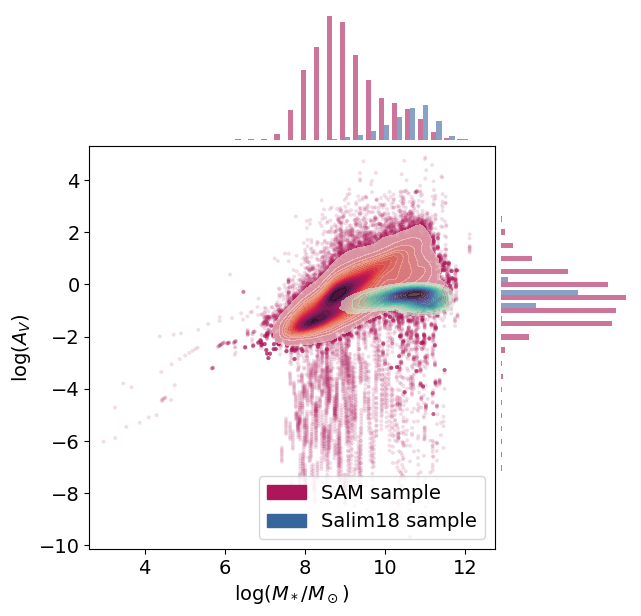

In [15]:
# --- Masks & precomputation ---
mask1 = Av_corrected > 0
mask2 = Av_salim > 0

log_stellar1 = np.log10(stellar_mass[mask1])
Av1 = np.log10(Av_corrected[mask1])
log_stellar2 = log_mstar_salim[mask2]
Av2 = np.log10(Av_salim[mask2])

print(max(Av1), max(Av2))

# --- Colors ---
c1, c2 = sns.color_palette("rocket_r")[3], sns.color_palette("mako_r")[3]

# --- Figure & gridspec ---
fig = plt.figure(figsize=(7, 7))
gs = GridSpec(4, 4, figure=fig, hspace=0.05, wspace=0.05)

ax_main = fig.add_subplot(gs[1:, :-1])
ax_xhist = fig.add_subplot(gs[0, :-1], sharex=ax_main)
ax_yhist = fig.add_subplot(gs[1:, -1], sharey=ax_main)

# --- Faint scatter points (SAM sample) ---
ax_main.scatter(
    log_stellar1, Av1,
    color=c1, alpha=0.15, s=8, edgecolor="none", zorder=1
)

# --- Main KDEs ---
sns.kdeplot(x=log_stellar1, y=Av1, fill=True, cmap="rocket_r", alpha=0.6, ax=ax_main, levels = 20)
sns.kdeplot(x=log_stellar2, y=Av2, fill=True, cmap="mako_r", alpha=0.6, ax=ax_main, levels = 20)

# --- Marginal histograms ---
bins_x = np.linspace(min(log_stellar1.min(), log_stellar2.min()),
                     max(log_stellar1.max(), log_stellar2.max()), 30)

bins_y = np.linspace(min(Av1.min(), Av2.min()),
                     max(Av1.max(), Av2.max()), 30)

ax_xhist.hist([log_stellar1, log_stellar2], bins=bins_x,
              color=[c1, c2], alpha=0.6, label=["SAM", "Salim"])
ax_yhist.hist([Av1, Av2], bins=bins_y,
              orientation='horizontal', color=[c1, c2], alpha=0.6)

# --- Clean up ---
ax_xhist.axis('off')
ax_yhist.axis('off')
ax_main.set(xlabel=r"$\log(M_*/M_\odot)$", ylabel=r"$\log(A_V)$") # ylim=(-5,5)

# --- Legend ---
ax_main.legend(
    handles=[
        mpatches.Patch(color=c1, label="SAM sample"),
        mpatches.Patch(color=c2, label="Salim18 sample")
    ],
    loc='lower right'
)

plt.show()


2.1128682555490617 0.26772539423567643


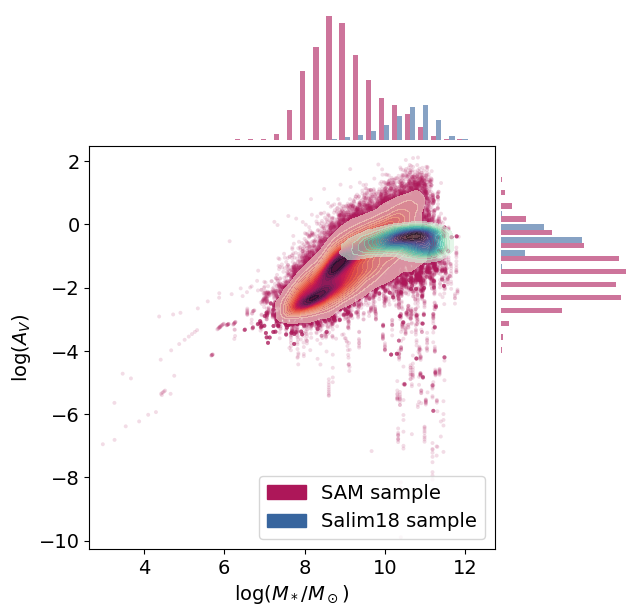

In [11]:
# --- Masks & precomputation ---
mask1 = Av_filtered > 0
mask2 = Av_salim > 0

log_stellar1 = np.log10(stellar_mass_filtered[mask1])
Av1 = np.log10(Av_filtered[mask1])
log_stellar2 = log_mstar_salim[mask2]
Av2 = np.log10(Av_salim[mask2])

print(max(Av1), max(Av2))

# --- Colors ---
c1, c2 = sns.color_palette("rocket_r")[3], sns.color_palette("mako_r")[3]

# --- Figure & gridspec ---
fig = plt.figure(figsize=(7, 7))
gs = GridSpec(4, 4, figure=fig, hspace=0.05, wspace=0.05)

ax_main = fig.add_subplot(gs[1:, :-1])
ax_xhist = fig.add_subplot(gs[0, :-1], sharex=ax_main)
ax_yhist = fig.add_subplot(gs[1:, -1], sharey=ax_main)

# --- Faint scatter points (SAM sample) ---
ax_main.scatter(
    log_stellar1, Av1,
    color=c1, alpha=0.15, s=8, edgecolor="none", zorder=1
)

# --- Main KDEs ---
sns.kdeplot(x=log_stellar1, y=Av1, fill=True, cmap="rocket_r", alpha=0.6, ax=ax_main, levels = 20)
sns.kdeplot(x=log_stellar2, y=Av2, fill=True, cmap="mako_r", alpha=0.6, ax=ax_main, levels = 20)

# --- Marginal histograms ---
bins_x = np.linspace(min(log_stellar1.min(), log_stellar2.min()),
                     max(log_stellar1.max(), log_stellar2.max()), 30)

bins_y = np.linspace(min(Av1.min(), Av2.min()),
                     max(Av1.max(), Av2.max()), 30)

ax_xhist.hist([log_stellar1, log_stellar2], bins=bins_x,
              color=[c1, c2], alpha=0.6, label=["SAM", "Salim"])
ax_yhist.hist([Av1, Av2], bins=bins_y,
              orientation='horizontal', color=[c1, c2], alpha=0.6)

# --- Clean up ---
ax_xhist.axis('off')
ax_yhist.axis('off')
ax_main.set(xlabel=r"$\log(M_*/M_\odot)$", ylabel=r"$\log(A_V)$") # ylim=(-5,5)

# --- Legend ---
ax_main.legend(
    handles=[
        mpatches.Patch(color=c1, label="SAM sample"),
        mpatches.Patch(color=c2, label="Salim18 sample")
    ],
    loc='lower right'
)

plt.show()


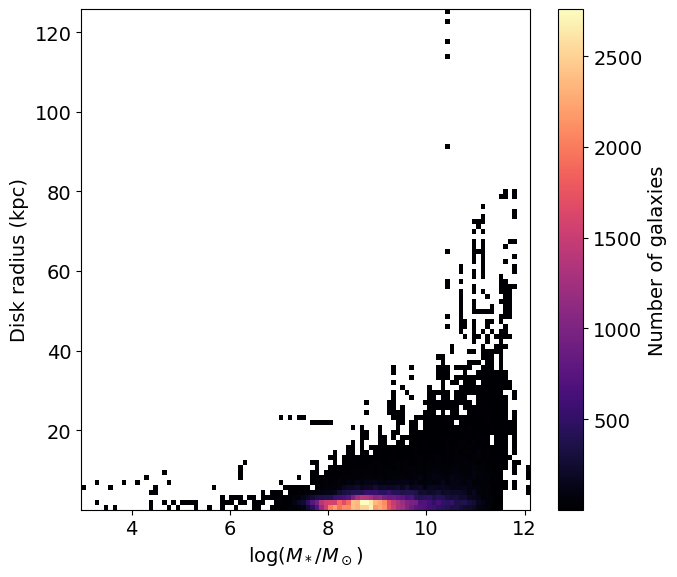

In [14]:
x = np.log10(stellar_mass)
y = disk_radius

plt.figure(figsize=(7, 6))
h = plt.hist2d(x, y, bins=100, cmap="magma", cmin=1)  # cmin=1 hides empty bins

# Add colorbar
cb = plt.colorbar(h[3])
cb.set_label("Number of galaxies")

# Labels
plt.xlabel(r"$\log(M_*/M_\odot)$")
plt.ylabel(r"Disk radius (kpc)")

plt.tight_layout()
plt.show()

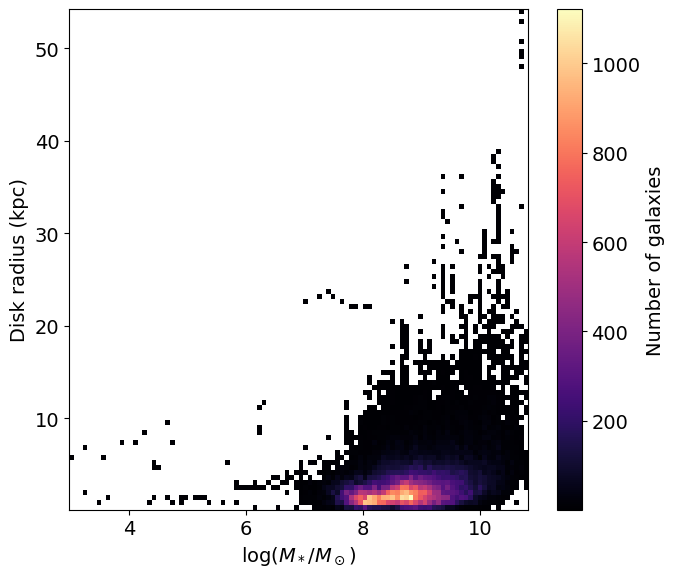

In [15]:
x = np.log10(stellar_mass_filtered)
y = disk_radius_filtered

plt.figure(figsize=(7, 6))
h = plt.hist2d(x, y, bins=100, cmap="magma", cmin=1)  # cmin=1 hides empty bins

# Add colorbar
cb = plt.colorbar(h[3])
cb.set_label("Number of galaxies")

# Labels
plt.xlabel(r"$\log(M_*/M_\odot)$")
plt.ylabel(r"Disk radius (kpc)")

plt.tight_layout()
plt.show()